## Budget in MITgcm. Part I: Heat budget
**15 August 2019 by MiniUFO and Emily**

---
[TOC]

---
### 1. Introduction
It is now a common practice for modeller to carry out heat/salt budget after numerical simulations.  Doing some budget analyses help find the reasons why their simulation is good/bad.  The long-term balance of heat/salt (in some integral sense) is also crucial for the climatological states produced by a model.

As Part I here we will do some budget diagnostics using the model of [MITgcm](http://mitgcm.org/), and its related [python](https://www.python.org/) analysis package like [xmitgcm](https://github.com/xgcm/xmitgcm) and [xgcm](https://github.com/xgcm/xgcm).  It will show that the budget diagnostics are very convenient under the help of these packages

---

### 2. Theoretical guide
###### 2.1 General equation for heat
The oceanic fluid simulated by MITgcm is driven by wind stress and buoyancy forcings.  These forcings exsert their effects at the surface and their energy input is eventually dissipated by visous or radiative processes.

For heat (potential temperature $\theta$), the budget equation reads:
> $$\frac{\partial \theta}{\partial t}=-\mathbf u\cdot \nabla \theta+\nabla\cdot(\kappa \nabla \theta)+F\tag{1}$$

where the 1st term on the rhs is advective contribution, 2nd term the explicit diffusion, and 3rd all the other forcings.

###### 2.2 Parameterization of mixing
In a typical simulation by MITgcm, turbulent mixing are also parameterized in certain forms other than the harmonic diffusion (i.e., the 2nd term on the rhs), like the [non-local KPP](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/94RG01872) (``` useKPP=.True.```), adiabatic [GM](https://journals.ametsoc.org/doi/abs/10.1175/1520-0485%281990%29020%3C0150%3AIMIOCM%3E2.0.CO%3B2) and diapycnal [Redi](https://journals.ametsoc.org/doi/abs/10.1175/1520-0485%281982%29012%3C1154%3AOIMBCR%3E2.0.CO%3B2) (GM and Redi schemes are combined into the GMRedi package ``` useGMRedi=.True.```).  It is worth noting that the effect of GMRedi has been included in the model-output diffusive fluxes (**TODO: need some proof**).  As a result, only KPP package should be included as:
>$$\frac{\partial \theta}{\partial t}=-\mathbf u\cdot \nabla \theta+\nabla\cdot(\kappa \nabla \theta)+KPP+F\tag{2}$$

###### 2.3 Relax or sponge effects
There are also cases in which relaxation effects (``` useRBCS=.True.```) or sponge boundary condition (``` useOBCS=.True.```) are imposed (preventing the model state from drifting or wave reflection at the boundary).  As a result, the restoring contribution should be added:
>$$\frac{\partial \theta}{\partial t}=-\mathbf u\cdot \nabla \theta+\nabla\cdot(\kappa \nabla \theta)+KPP+restore+F\tag{3}$$

It is noted here that the ```RBCS``` and ```OBCS``` do not provide any diagnostics.  However, there is a ```TRELAX``` diagnostics representing the surface temperature relaxation (need to verify that this is or is not all relaxations).

###### 2.4 Radiative forcings
Lastly, the forcing term *F* includes four components: short-wave radiative incoming heating, long-wave radiative outgoing cooling, sensible heat flux and latent heat flux.  Usually, the short-wave heating (Qsflx) is separated from the rest three and the last three are summed up as surface heat flux (Qtflx):
>$$\frac{\partial \theta}{\partial t}=-\mathbf u\cdot \nabla \theta+\nabla\cdot(\kappa \nabla \theta)+KPP+restore+Q_{sflx}+Q_{tflx}\tag{4}$$

###### 2.5 Linear surface correction
The implementation of the linear surface motion by MITgcm requires a surface correction because there is a small loss of heat/salt/tracer at the surface ($d\eta/dt$) inconsistent with fixed surface grid cell thickness [(see this document)](http://wwwcvs.mitgcm.org/viewvc/MITgcm/MITgcm/doc/diags_changes.txt?view=markup).  If ``` linFSConserveTr=True```, the model will correct for this (see S/R [calc_wsurf_tr.F]()).  If ``` linFSConserveTr=False``` (default), the term corresponding to $w_{sfc}\theta$ is missing in TFLUX to match exactly the heat budget (```ADVr_TH``` is not the right one for this purpose, it is just zero at the surface where ```k=1```).  The purpose of setting ```linFSConserveTr=.TRUE.``` is to correct (globally) for the integral of ```WTHMASS(k=1)```.
This correction (TsurfCor, SsurfCor) is applied uniformly to the surface level.
>$$\frac{\partial \theta}{\partial t}=-\mathbf u\cdot \nabla \theta+\nabla\cdot(\kappa \nabla \theta)+KPP+restore+Q_{sflx}+Q_{tflx}+correct \tag{5}$$

The tendency due to the surface correction is:
>$$correct=\frac{(WTH_{mean}-w\theta)}{\delta z} \tag{6}$$

where $\delta z$ is the thickness of the surface layer, and $WTH_{mean}$ is the surface-mean vertical heat transport:
>$$WTH_{mean}=\frac{\iint w\theta dA}{\iint dA} \tag{7}$$

when using ```linFSConserveTR = True```.  If ```linFSConserveTR = False```, this transport should be exactly zero.

---

### 3. Practice using xgcm/xmitgcm
According to the above, the T-tendency (Ttdc) budget equation is:

**total_Ttdc = advct_Ttdc + diffu_Ttdc + nlKPP_Ttdc + relax_Ttdc + Qsflx_Ttdc + Qtflx_Ttdc**

The MITgcm output diagnostics required for the heat budget are:

| Names in Equation |  Outpus required by MITgcm  | Description |
| ------------: | --------------------------- | ------------------- |
|   total_Ttdc | ```TOTTEND``` | total tendency of potential temperature |
|  advct_Ttdc | ```ADVx_TH```, ```ADVy_TH```, ```ADVr_TH``` | tendency due to 3D advection |
|   diffu_Ttdc | ```DFxE_TH```, ```DFyE_TH```, ```DFrE_TH```, ```DFrI_TH``` | tendency due to 3D diffusion, both explicit and implicit |
|  nlKPP_Ttdc | ```KPPg_TH``` | tendency due to KPP parameterization |
|   relax_Ttdc | ```TRELAX``` | tendency due to relaxation? (there is no diagnostics by RBCS and OBCS) |
|   Qsflx_Ttdc | ```oceQsw```, ```TFLUX``` | tendency due to incoming short-wave radiation near surface |
|   Qtflx_Ttdc | ```oceQsw```, ```TFLUX``` | tendency due to the sum of outgoing long-wave radiation, sensible heat flux and latent heat flux at the surface |
|   corrt_Ttdc | ```WTHMASS``` | tendency due to the  surface correction |

One can find these names in available_diagnosis.log generated in the run directory and set them in data.diagnostics for output.  Then we start the budget analysis using [python](https://www.python.org/) and related packages.

First, we defined a [HeatBudget]() class in Python code.  Using the [HeatBudget]() class, the heat budget can be easily diagnosed like:


In [2]:
import matplotlib.pyplot as plt
import xmitgcm
import xarray as xr
import sys
sys.path.append('../Python/MyPack/')
from GeoApps.Budget import HeatBudget
from GeoApps.GridUtils import add_MITgcm_missing_metrics

###  loading data  ###
datadir = 'I:/channel/output_budget/'
griddir = 'I:/channel'

deltaTmom = 300

dset = xmitgcm.open_mdsdataset(datadir, grid_dir=griddir,
                    delta_t=deltaTmom, read_grid=True,
                    prefix=['Stat3D', 'Surf2D', 'DiagT'])

dset, grid = add_MITgcm_missing_metrics(dset, periodic='X')


###  do the budget  ###
budget = HeatBudget(dset, grid)

# obtains variables
TOTTTEND = dset['TOTTTEND']

ADVx_TH  = dset['ADVx_TH' ]
ADVy_TH  = dset['ADVy_TH' ]
ADVr_TH  = dset['ADVr_TH' ]

DFxE_TH  = dset['DFxE_TH' ]
DFyE_TH  = dset['DFyE_TH' ]
DFrE_TH  = dset['DFrE_TH' ]
DFrI_TH  = dset['DFrI_TH' ]

KPPg_TH  = dset['KPPg_TH' ]
TFLUX    = dset['TFLUX'   ]
oceQsw   = dset['oceQsw'  ]
WTHMASS  = dset['WTHMASS' ]
#TRELAX   = dset['TRELAX'  ] # need this if relax is on?

budget.cal_true_tendency(TOTTTEND)
budget.cal_advection_tendency(ADVx_TH, ADVy_TH, ADVr_TH)
budget.cal_diffusion_tendency(DFxE_TH, DFyE_TH, DFrE_TH, DFrI_TH)
budget.cal_nlocalKPP_tendency(KPPg_TH)
budget.cal_heating_flux_tendency(TFLUX, oceQsw)
budget.cal_linFSCorr_tendency(WTHMASS)

re = budget.terms # results are stored in a xarray.Dataset

total =  re.total_tdc
sumup = (re.advct_tdc + # advective tendency = adv_x_tdc + adv_y_tdc + adv_r_tdc
         re.diffu_tdc + # diffusive tendency = dffxE_tdc + dffyE_tdc + dffrE_tdc + dffrI_tdc
         re.nlKPP_tdc +
         re.Qsflx_tdc +
         re.Qtflx_tdc +
         re.corrt_tdc)

C:\Users\Administrator\Anaconda3\lib\site-packages\xmitgcm\mds_store.py:217: FutureWarning: In xarray version 0.15 `auto_combine` will be deprecated. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi
  ds = xr.auto_combine(datasets)
C:\Users\Administrator\Anaconda3\lib\site-packages\xmitgcm\mds_store.py:217: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).The datasets supplied require both concatenation and merging. From
xarray version 0.15 this will operation will require either using the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset), with a nested list stru

We then get a Dataset named ```re```, and it contains all the related heat budget terms:

In [3]:
print(re)

<xarray.Dataset>
Dimensions:    (XC: 200, YC: 400, Z: 30, time: 3)
Coordinates:
  * Z          (Z) float64 -5.0 -15.0 -27.5 ... -2.58e+03 -2.83e+03 -3.08e+03
    iter       (time) int32 dask.array<chunksize=(1,), meta=np.ndarray>
  * time       (time) int64 1866250800 1866261600 1866272400
  * XC         (XC) >f4 2500.0 7500.0 12500.0 ... 987500.0 992500.0 997500.0
  * YC         (YC) >f4 2500.0 7500.0 12500.0 ... 1987500.0 1992500.0 1997500.0
    rA         (YC, XC) >f4 dask.array<chunksize=(400, 200), meta=np.ndarray>
    Depth      (YC, XC) >f4 dask.array<chunksize=(400, 200), meta=np.ndarray>
    drF        (Z) >f4 dask.array<chunksize=(30,), meta=np.ndarray>
    PHrefC     (Z) >f4 dask.array<chunksize=(30,), meta=np.ndarray>
    RhoRef     (Z) >f4 dask.array<chunksize=(30,), meta=np.ndarray>
    hFacC      (Z, YC, XC) >f4 dask.array<chunksize=(30, 400, 200), meta=np.ndarray>
    maskC      (Z, YC, XC) bool dask.array<chunksize=(30, 400, 200), meta=np.ndarray>
    maskInC    (YC, X

Here I only demonstrate the top APIs of [HeatBudget]() for potential users, no specific implement details although it is not complicated.  Such API designs aim to **let the codes be the comments**: what variables are needed for each process.  Finally we get all the terms in a `xarray.Dataset`, which would be convenient to write to disk (as a [NetCDF](https://www.unidata.ucar.edu/software/netcdf/) file).  Note that the advective and diffusive tendencies are also separated into different `(x, y, r)` or `(implicit, explicit)` components stored in `re`.

As the calculation is completed, we can demonstrate the contributions from all kinds of processes and verify that the sum up of all processes is exactly the total tendency for heat.  Here we select four points for demonstration: **in the interior ocean**, **in the sponge boundary**, **in the subsuface** and **at the surface**.  All the terms are in unit of K per day.

start  loading data


C:\Users\Administrator\Anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)
C:\Users\Administrator\Anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*args2)


start plotting


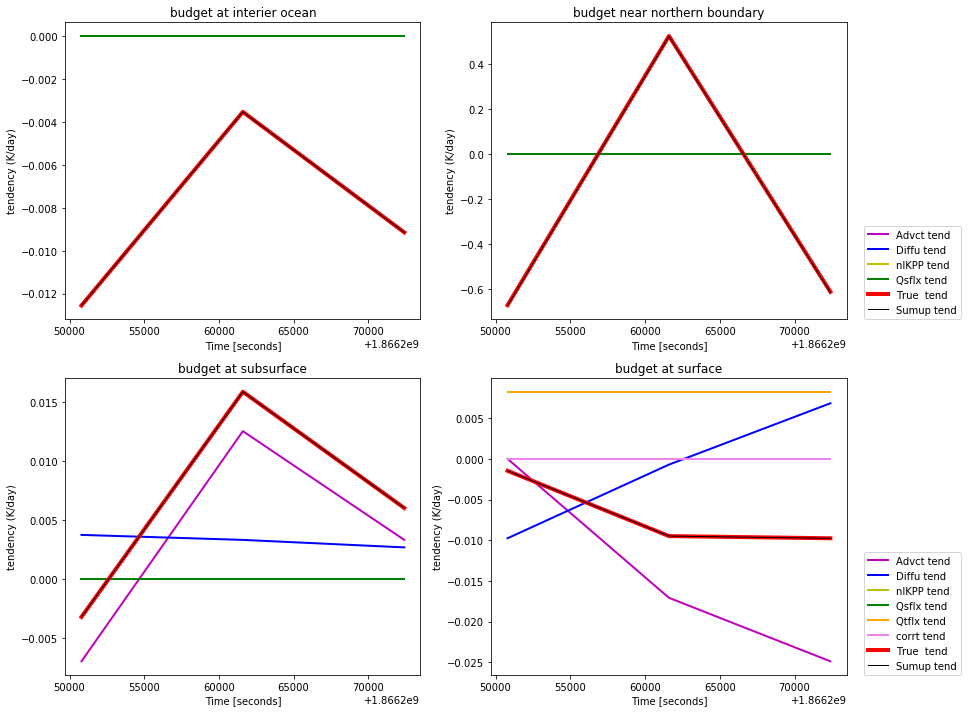

In [19]:
print('start  loading data')
# P1: interier ocean, P2: northern BC, P3: subsurface, P4: surface
#                                P1, P2, P3, P4
parts = re.isel(XC=xr.DataArray([50, 50, 50, 50], dims='point'),
                YC=xr.DataArray([50,396, 50, 50], dims='point'),
                Z =xr.DataArray([14, 14,  3,  0], dims='point')).load()


print('start plotting')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2,figsize=(14, 12))
data = parts.isel(point=0)
sums = (data['advct_tdc'] + data['diffu_tdc'] +
        data['nlKPP_tdc'] + data['Qsflx_tdc'])

data['advct_tdc'].plot(ax=ax1, color='m', linewidth=2, label='Advct tend')
data['diffu_tdc'].plot(ax=ax1, color='b', linewidth=2, label='Diffu tend')
data['nlKPP_tdc'].plot(ax=ax1, color='y', linewidth=2, label='nlKPP tend')
data['Qsflx_tdc'].plot(ax=ax1, color='g', linewidth=2, label='Qsflx tend')
data['total_tdc'].plot(ax=ax1, color='r', linewidth=4, label='True  tend')
sums             .plot(ax=ax1, color='k', linewidth=1, label='Sumup tend')

ax1.set_ylabel('tendency (K/day)')
ax1.set_title('budget at interier ocean')

data = parts.isel(point=1)
sums = (data['advct_tdc'] + data['diffu_tdc'] +
        data['nlKPP_tdc'] + data['Qsflx_tdc'])

data['advct_tdc'].plot(ax=ax2, color='m', linewidth=2, label='Advct tend')
data['diffu_tdc'].plot(ax=ax2, color='b', linewidth=2, label='Diffu tend')
data['nlKPP_tdc'].plot(ax=ax2, color='y', linewidth=2, label='nlKPP tend')
data['Qsflx_tdc'].plot(ax=ax2, color='g', linewidth=2, label='Qsflx tend')
data['total_tdc'].plot(ax=ax2, color='r', linewidth=4, label='True  tend')
sums             .plot(ax=ax2, color='k', linewidth=1, label='Sumup tend')

ax2.set_ylabel('tendency (K/day)')
ax2.set_title('budget near northern boundary')
ax2.legend(loc=[1.05, 0])

data = parts.isel(point=2)
sums = (data['advct_tdc'] + data['diffu_tdc'] +
        data['nlKPP_tdc'] + data['Qsflx_tdc'])

data['advct_tdc'].plot(ax=ax3, color='m', linewidth=2, label='Advct tend')
data['diffu_tdc'].plot(ax=ax3, color='b', linewidth=2, label='Diffu tend')
data['nlKPP_tdc'].plot(ax=ax3, color='y', linewidth=2, label='nlKPP tend')
data['Qsflx_tdc'].plot(ax=ax3, color='g', linewidth=2, label='Qsflx tend')
data['total_tdc'].plot(ax=ax3, color='r', linewidth=4, label='True  tend')
sums             .plot(ax=ax3, color='k', linewidth=1, label='Sumup tend')

ax3.set_ylabel('tendency (K/day)')
ax3.set_title('budget at subsurface')

data = parts.isel(point=3)
sums = (data['advct_tdc'] + data['diffu_tdc'] +
        data['nlKPP_tdc'] + data['Qsflx_tdc'] +
        data['Qtflx_tdc'] + data['corrt_tdc'])

data['advct_tdc'].plot(ax=ax4, color='m'     , linewidth=2, label='Advct tend')
data['diffu_tdc'].plot(ax=ax4, color='b'     , linewidth=2, label='Diffu tend')
data['nlKPP_tdc'].plot(ax=ax4, color='y'     , linewidth=2, label='nlKPP tend')
data['Qsflx_tdc'].plot(ax=ax4, color='g'     , linewidth=2, label='Qsflx tend')
data['Qtflx_tdc'].plot(ax=ax4, color='orange', linewidth=2, label='Qtflx tend')
data['corrt_tdc'].plot(ax=ax4, color='violet', linewidth=2, label='corrt tend')
data['total_tdc'].plot(ax=ax4, color='r'     , linewidth=4, label='True  tend')
sums             .plot(ax=ax4, color='k'     , linewidth=1, label='Sumup tend')

ax4.set_ylabel('tendency (K/day)')
ax4.set_title('budget at surface')
ax4.legend(loc=[1.05, 0])

From the above figure, we can see that heat tendency budgets are all closed (exact overlap of **True tendency** and **sum-up tendency**).

#### References
1. <http://pangeo.io/use_cases/physical-oceanography/SOSE.html>
2. <http://mitgcm.org/download/daily_snapshot/MITgcm/doc/Heat_Salt_Budget_MITgcm.pdf>
3. <http://wwwcvs.mitgcm.org/viewvc/MITgcm/MITgcm/doc/diags_changes.txt?view=markup>
4. <http://mailman.mitgcm.org/pipermail/mitgcm-support/2014-November/009586.html>
5. <http://mailman.mitgcm.org/pipermail/mitgcm-support/2014-April/009077.html>
6. <http://mailman.mitgcm.org/pipermail/mitgcm-support/2011-May/007185.html>